In [26]:
from langchain_openai import ChatOpenAI

from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore

##Langgraph
from langchain_core.messages import HumanMessage, AIMessage,ToolMessage
from langchain.agents import initialize_agent, Tool
from langchain.llms import OpenAI
from langchain_openai import ChatOpenAI
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain.tools import tool

from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool,InjectedToolCallId
from langgraph.prebuilt import ToolNode,InjectedState,create_react_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import AgentExecutor
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig
from langgraph.types import Command, interrupt

In [27]:
import openai
import sys
import importlib
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import json
import re
import random
from collections import Counter



In [28]:
OPENAI_API_KEY = ""
OPENAI_MODEL = "o4-mini" # "gpt-4o" "o4-mini" #gpt-3.5-turbo"

In [29]:
model = ChatOpenAI(api_key=OPENAI_API_KEY,model=OPENAI_MODEL)

In [30]:
checkpointer = InMemorySaver()
store = InMemoryStore()

<img src="./images/data_insights_agent_architecture1.png" alt="Description">

In [41]:
df = pd.read_csv('./file/amazon_reviews_5.csv')
df.head(5)

,ProductId,Score,Review
0,B003XPF9BO,5,where does one start...and stop... with a tre...
1,B003JK537S,1,Arrived in pieces; Not pleased at all. When I ...
2,B000JMBE7M,4,"It isn't blanc mange, but isn't bad . . .; I'm..."
3,B004AHGBX4,3,These also have SALT and it's not sea salt.; I...
4,B001BORBHO,5,Happy with the product; My dog was suffering w...


<img src="./images/sentiment.png" alt="Description">

In [32]:
##Get Sentiment
def get_openai_text_sentiment_1(text,model):
        client = openai.OpenAI(api_key=OPENAI_API_KEY)
        text = text.replace("\n", " ")
        error = ''
        #max_tokens = 100

        
        ##Prompt engineering
        system_prompt = '''You are an assistant that reviews text and identifies the sentiment as well as probability of the sentiment.
        The sentiment is either POSITIVE, NEUTRAL or NEGATIVE. The probability is between 0 and 1.
        The output has to be in csv format. 
        For example if the sentiment of text of positive, the output is POSITIVE, probability between 0 and 1.
        If the sentiment of text of neutral, the output is NEUTRAL, probability between 0 and 1.
        If the sentiment of text of negative, the output is NEGATIVE, probability between 0 and 1.
        
        '''
        user_topic_prompt = """Please give sentiment and probability of following text: 
                ####
                <TXT_DATA>
                ####
                """     
        
        user_topic_prompt = user_topic_prompt.replace('<TXT_DATA>',text)
        messages_param=[{"role": "system", "content": system_prompt},{"role": "user", "content": user_topic_prompt}]
        
        try:
            ##Get OpenAI Response
            response = client.chat.completions.create(
                    model=model, 
                    messages=messages_param
                )
            
            res = response.choices[0].message.content
            
            res = res.replace("\n", "")
            res = res.replace(" ", "")
            
            res = re.sub(r'positive', 'POSITIVE', res, flags=re.IGNORECASE)
            res = re.sub(r'negative', 'NEGATIVE', res, flags=re.IGNORECASE)
            res = re.sub(r'neutral', 'NEUTRAL', res, flags=re.IGNORECASE)
        
            sentiment = 'NEUTRAL'
            prob = 0.0
            
            if 'POSITIVE' in res:
                prob = get_float_number_from_string(res)
                prob = prob + random.uniform(-0.05, 0.05)
                sentiment = 'POSITIVE'

            if 'NEGATIVE' in res:
                prob = get_float_number_from_string(res)
                prob = prob + random.uniform(-0.05, 0.05)
                sentiment = 'NEGATIVE'

            if 'NEUTRAL' in res:
                prob = get_float_number_from_string(res)
                prob = prob + random.uniform(-0.05, 0.05)
                sentiment = 'NEUTRAL'

            if prob < 0.0:
                prob = 0.0
            if prob > 1.0:
                prob = 1.0
            
            

        except Exception as e:
            print ('Sentiment analysis error..'+str(e))
            sentiment = 'NEUTRAL'
            prob = 0.0  
            error = e
            
            
        print ('openai..',text,sentiment,prob,error)

        return pd.Series([sentiment, prob], index=['sentiment', 'probability'])

In [33]:
def get_float_number_from_string(text):
        # Regular expression pattern to match a float number
        pattern = r"[-+]?\d*\.\d+|\d+"

        # Find all matches in the string
        matches = re.findall(pattern, text)

        # Get the first match (float number)
        if matches:
            first_float = float(matches[0])
        
        else:
            first_float = 0.0
        
        return first_float

<img src="./images/top10_words1.png" alt="Description">

In [34]:
def get_top_words_for_group(df, col_txt, col_groupby, n_words):
        """
        Get top n words for each group, excluding stop words
        
        
        """

        stop_words =  [
    "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "aren't", "as", "at", 
    "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", 
    "can't", "cannot", "could", "couldn't", 
    "did", "didn't", "do", "does", "doesn't", "doing", "don't", "down", "during", 
    "each", 
    "few", "for", "from", "further", 
    "had", "hadn't", "has", "hasn't", "have", "haven't", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", 
    "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "isn't", "it", "it's", "its", "itself", 
    "let's", 
    "me", "more", "most", "mustn't", "my", "myself", 
    "no", "nor", "not", 
    "of", "off", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", 
    "same", "shan't", "she", "she'd", "she'll", "she's", "should", "shouldn't", "so", "some", "such", 
    "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", 
    "under", "until", "up", 
    "very", 
    "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "won't", "would", "wouldn't", 
    "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"
        ]
        
        # Add any custom stop words if needed
        # stop_words.update(['word1', 'word2'])
        
        result_dict = {}
        
        # Group by cluster
        for group_name, group in df.groupby(col_groupby):
            # Combine all text for this cluster
            all_text = ' '.join(group[col_txt].astype(str).tolist())
            
            # Clean and tokenize text
            words = re.findall(r'\b[a-zA-Z]+\b', all_text.lower())  # Extract words, convert to lowercase
            
            # Remove stop words and filter short words
            filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
            
            # Count word frequencies
            word_counts = Counter(filtered_words)
            
            # Get top n words
            top_words = [word for word, count in word_counts.most_common(n_words)]
            
            # Convert to comma-separated string
            result_dict[group_name] = ', '.join(top_words)
        
        return result_dict

<img src="./images/sentiment_analysis_tool_datainsights.png" alt="Description">

In [35]:
# Create tools, which will be later used by specialized agent
##Defining the sentiment analysis tool
def sentimentanalysis_tool(col_txt:str, input_datafile:str) -> str:
    """Perform sentiment analysis on specified columns of a DataFrame. 
         
        
        Args:
            col_txt: Column for sentiment analysis
            input_datafile: Name of file to get input data
            
    """
    try:
        
        print ('input_datafile..',input_datafile)
        ##Reading data
        df = pd.read_csv(input_datafile)
        

        #Convert all values into string
        df[col_txt] = df[col_txt].astype(str)

        ##Get Sentiment Analysis using OpenAI Model
        model= "gpt-3.5-turbo"  #We use this model as it is not reasoning model, so results are retrieved faster 
        new_cols = df.apply(lambda row: get_openai_text_sentiment_1(row[col_txt],model), axis=1)
        df_sentiment = pd.concat([df, new_cols], axis=1)
        df_sentiment['count'] = 1
        

        file_out_name = 'sentimenttool_results.csv'
        file_out = './output/'+file_out_name
        df_sentiment.to_csv(file_out,index=False)
        df_sentiment.head(5)

        dct_topwords = get_top_words_for_group(df_sentiment, col_txt, 'sentiment', 10)
        
        #Create visualization
        sns.barplot(data=df_sentiment, x='sentiment', y='count', estimator=sum, ci=None)
        sns.set_style("whitegrid")

        
        
        
        response = 'Sentiment Analysis for '+col_txt+' has been calculated'
        response = response + ' The Top words by sentiment are:'+json.dumps(dct_topwords, indent=2)
        print ('response..',response)
    except Exception as e:
        print ('Sentiment analysis error..'+str(e))
        response = "Unfortuanately some error occured while calculating sentiment analysis."    
    
    return response


    





In [36]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm=ChatOpenAI(temperature=1,api_key=OPENAI_API_KEY, model="o4-mini") #gpt-3.5-turbo

tools = [sentimentanalysis_tool]
llm_with_tools = llm.bind_tools(tools) 
memory = MemorySaver()

def chatbot(state: State):
    #print ('state["messages"]...',state["messages"])
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer = memory)

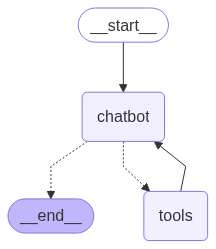

In [37]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [38]:
query = "Give me sentiment analysis of Review. Also Input file is ./file/amazon_reviews_5.csv. Give an interpretation of results."

input_datafile.. ./file/amazon_reviews_5.csv
openai.. where does one  start...and stop... with a treat like this; Wanted to save some to bring to my Chicago family but my North Carolina family ate all 4 boxes before I could pack. These are excellent...could serve to anyone POSITIVE 0.96319370840629 
openai.. Arrived in pieces; Not pleased at all. When I opened the box, most of the rings were broken in pieces. A total waste of money. NEGATIVE 0.9790580956123293 
openai.. It isn't blanc mange, but isn't bad . . .; I'm not sure that custard is really custard without eggs.  But this comes close.  I got it for use in a "Vegan pancake" recipe.  We were having houseguests who were Vegan and I wanted to make some special breakfasts while they were here.  One of the cooking/recipe sites had a recipe using this and there were lots of great reviews.  I tried the recipe and it turned out like wallpaper paste -- yuck!<br />However, the  so-called custard isn't so bad.  I think it's probably just co

/var/folders/vr/mpmvnq3921n9j9rgk4zmcltw0000gp/T/ipykernel_35177/737412727.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_sentiment, x='sentiment', y='count', estimator=sum, ci=None)


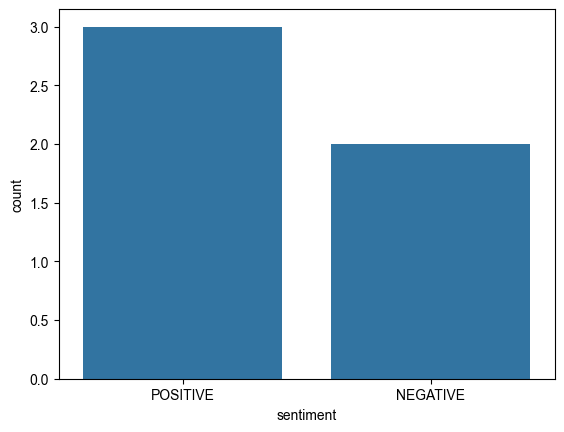

In [39]:
result = graph.invoke(
             {
                 "messages": [{"role": "user", "content": query}],

                
                 
                 },
             
              config={"configurable": {"thread_id": "123"}}, 
            )

In [40]:
for message in result['messages']:
    print (message.pretty_print())

================================ Human Message =================================

Give me sentiment analysis of Review. Also Input file is ./file/amazon_reviews_5.csv. Give an interpretation of results.
None
================================== Ai Message ==================================
Tool Calls:
  sentimentanalysis_tool (call_08BXNanK5xX5cPzTIsa1aCms)
 Call ID: call_08BXNanK5xX5cPzTIsa1aCms
  Args:
    col_txt: Review
    input_datafile: ./file/amazon_reviews_5.csv
None
================================= Tool Message =================================
Name: sentimentanalysis_tool

Sentiment Analysis for Review has been calculated The Top words by sentiment are:{
  "NEGATIVE": "salt, tuna, sea, pieces, like, can, preserved, glass, don, contact",
  "POSITIVE": "custard, recipe, like, isn, make, skin, one, wanted, family, blanc"
}
None
================================== Ai Message ==================================

Here’s what we found when running sentiment analysis over the “Review” 